Coefficients and Kernel vs. Kernel Derivative Contributions

In [1]:
import trig_poly
import dual_certificates
import test_data
import numpy as np
import plt_util
import phase_transition
from matplotlib import pyplot as plt

%matplotlib inline

In [179]:
reload(test_data)
reload(dual_certificates)
reload(trig_poly)

m = 10
fc = 50
min_separation = 0.65 / fc
N = int(1.0/min_separation)

kernel = trig_poly.TrigPoly.dirichlet(fc)

support = test_data.jittered_supports(N, min_separation=min_separation)
sign_pattern = test_data.uniform_sign_pattern_multidim(N, m)

In [180]:
interpolator = dual_certificates.interpolate_multidim_l2_min(support, sign_pattern, kernel)

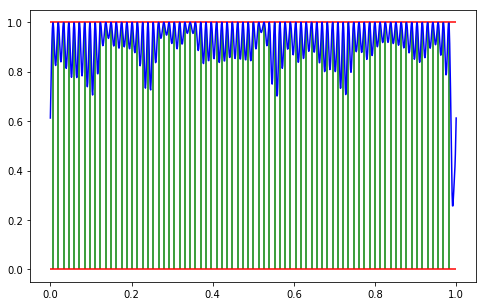

In [181]:
plt.subplots(figsize=(8,5))

plt_util.plot_trig_poly_magnitude(interpolator, points=1000)
plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds()

In [169]:
dual_certificates.validate(support, sign_pattern, interpolator)

{'bound_achieved': True,
 'max_deviation': 2.64070060411271e-13,
 'status': True,
 'values_achieved': True}

In [170]:
kernel_coeffs, kernel_derivative_coeffs = dual_certificates.interpolate_multidim_l2_min(
    support, sign_pattern, kernel, return_coeffs=True)

In [171]:
for i in range(m):
    print np.mean(np.abs(sign_pattern[:, i] - kernel_coeffs[i]))

0.659252260945
0.185338242012
0.925454752577
0.455503425395
0.21065408922
0.36881505587
0.351274794313
0.284042332942
1.41711480006
0.454358178649


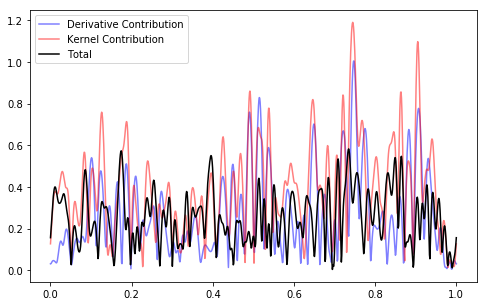

In [172]:
reload(plt_util)

plt.subplots(figsize=(8, 5))

m = 5

kernel_contrib = sum(
    (kernel.shift(-t) * kernel_coeffs[m][i] for i, t in enumerate(support)),
    trig_poly.TrigPoly.zero())
kernel_derivative_contrib = sum(
    (kernel.derivative().shift(-t) * kernel_derivative_coeffs[m][i] for i, t in enumerate(support)),
    trig_poly.TrigPoly.zero())

plt_util.plot_trig_poly_magnitude(kernel_derivative_contrib, label='Derivative Contribution', points=1000, alpha=0.5)
plt_util.plot_trig_poly_magnitude(kernel_contrib, c='red', label='Kernel Contribution', points=1000, alpha=0.5)
plt_util.plot_trig_poly_magnitude(kernel_contrib + kernel_derivative_contrib, c='black', label='Total', points=1000, alpha=1.0)
plt.legend()